# Digital Signal Processing — Image Processing Toolkit

This notebook covers core 2D DSP techniques applied to images:

1. **Spatial Filters** — Gaussian, median, low-pass, high-pass, band-pass
2. **Frequency Domain Analysis** — 2D FFT, magnitude/phase/power spectra
3. **Edge Detection** — Sobel, Laplacian, Canny
4. **Noise: Addition & Removal** — Gaussian, salt-and-pepper, denoising

---
**Dependencies:** `numpy`, `scipy`, `matplotlib`, `scikit-image`, `Pillow`

Install if needed:
```
pip install numpy scipy matplotlib scikit-image Pillow
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import ndimage, signal
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import data, filters, feature, color, util, restoration
from skimage.filters import gaussian, median, sobel, laplace
from skimage.morphology import disk
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

# ── Plotting helpers ──────────────────────────────────────────────────────────

def show(images, titles, cmap='gray', figsize=None, suptitle=None):
    """Display a row of images with titles."""
    n = len(images)
    figsize = figsize or (4 * n, 4)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    cmaps = cmap if isinstance(cmap, list) else [cmap] * n
    for ax, img, title, cm in zip(axes, images, titles, cmaps):
        ax.imshow(img, cmap=cm)
        ax.set_title(title, fontsize=11)
        ax.axis('off')
    if suptitle:
        fig.suptitle(suptitle, fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print('Imports OK.')

Imports OK.


## 0 · Load an Image

You can swap in **any image path** below, or keep the built-in `skimage` sample.

Image shape: (512, 512)  |  dtype: float64  |  range: [0.000, 1.000]


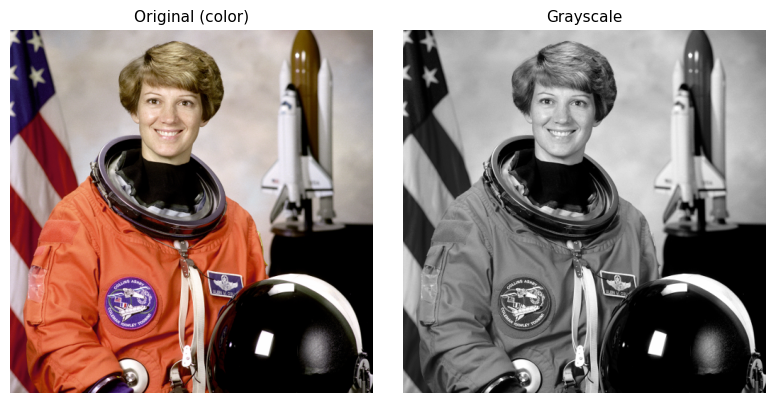

In [2]:
# ── Option A: built-in sample image ──────────────────────────────────────────
img_color = data.astronaut()            # RGB uint8
img = color.rgb2gray(img_color)         # grayscale float64 in [0, 1]

# ── Option B: load your own image (uncomment) ─────────────────────────────────
# img_pil   = Image.open('your_image.jpg').convert('RGB')
# img_color = np.array(img_pil)
# img       = color.rgb2gray(img_color)

print(f'Image shape: {img.shape}  |  dtype: {img.dtype}  |  range: [{img.min():.3f}, {img.max():.3f}]')
show([img_color, img], ['Original (color)', 'Grayscale'], cmap=['viridis', 'gray'])

---
## 1 · Spatial Filters

Spatial filters operate directly on pixel values.

| Filter | Effect |
|---|---|
| **Gaussian** | Smooth / blur; weights by distance (σ controls spread) |
| **Median** | Smooth while preserving edges; great for salt-and-pepper noise |
| **Low-pass (box)** | Average all neighbours equally; simpler blur |
| **High-pass** | Enhance fine detail = original − low-pass |
| **Band-pass** | Retain a range of spatial frequencies (DoG approach) |

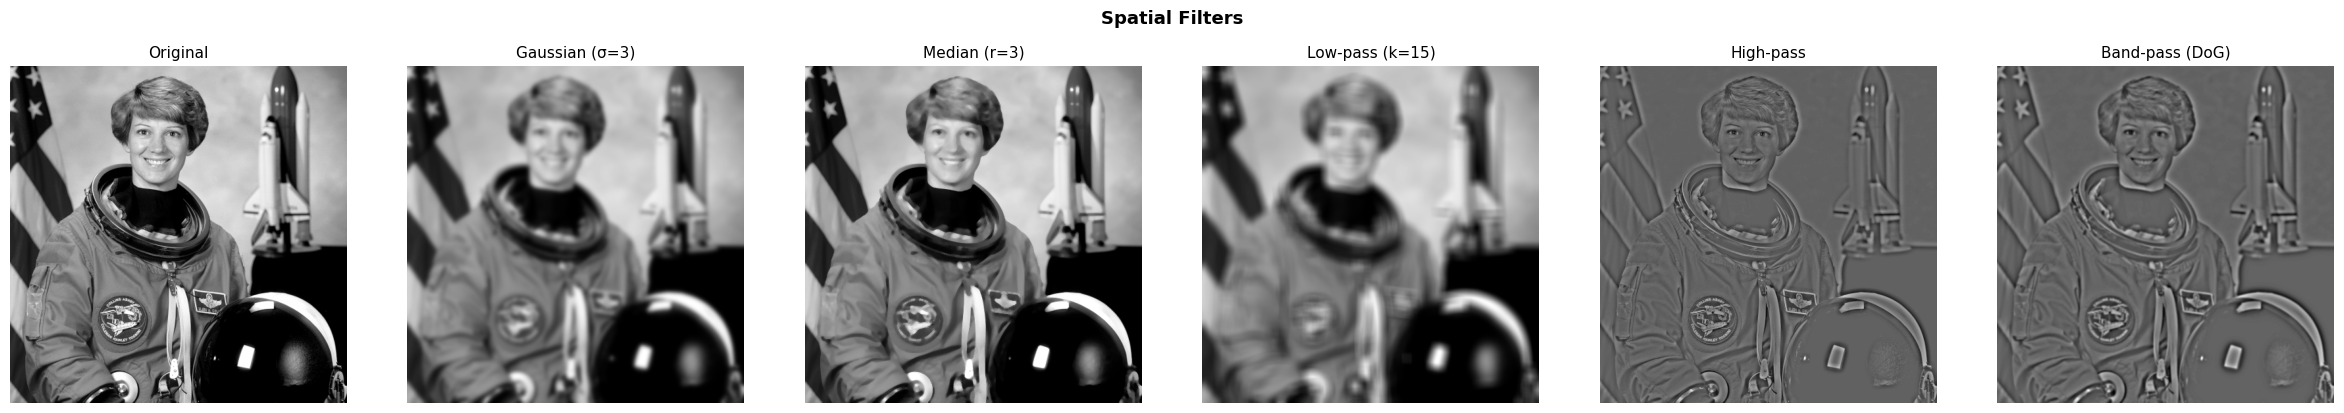

In [3]:
# ── Gaussian filter ───────────────────────────────────────────────────────────
sigma = 3           # ← tune: larger = more blur
gauss_filtered = gaussian(img, sigma=sigma)

# ── Median filter ─────────────────────────────────────────────────────────────
footprint_radius = 3    # ← tune: larger footprint = more smoothing
median_filtered = median(img, footprint=disk(footprint_radius))

# ── Low-pass (uniform box) filter ─────────────────────────────────────────────
kernel_size = 15        # ← tune: odd number; larger = more blur
kernel_lp   = np.ones((kernel_size, kernel_size)) / kernel_size**2
lowpass     = ndimage.convolve(img, kernel_lp)

# ── High-pass = original − low-pass ───────────────────────────────────────────
highpass = img - lowpass
highpass_display = (highpass - highpass.min()) / (highpass.max() - highpass.min())

# ── Band-pass (Difference of Gaussians) ───────────────────────────────────────
sigma_low  = 1.0    # ← tune: lower sigma = captures finer detail
sigma_high = 5.0    # ← tune: upper sigma = captures coarser detail
bandpass   = gaussian(img, sigma=sigma_low) - gaussian(img, sigma=sigma_high)
bandpass_display = (bandpass - bandpass.min()) / (bandpass.max() - bandpass.min())

show(
    [img, gauss_filtered, median_filtered, lowpass, highpass_display, bandpass_display],
    ['Original', f'Gaussian (σ={sigma})', f'Median (r={footprint_radius})',
     f'Low-pass (k={kernel_size})', 'High-pass', 'Band-pass (DoG)'],
    suptitle='Spatial Filters'
)

---
## 2 · Frequency Domain Analysis (2D FFT)

The 2D Discrete Fourier Transform decomposes the image into spatial frequencies.
Low frequencies (near centre) → gradual variations.  
High frequencies (near edges) → sharp edges, fine texture.

We also demonstrate **frequency-domain filtering** (ideal low-pass & high-pass).

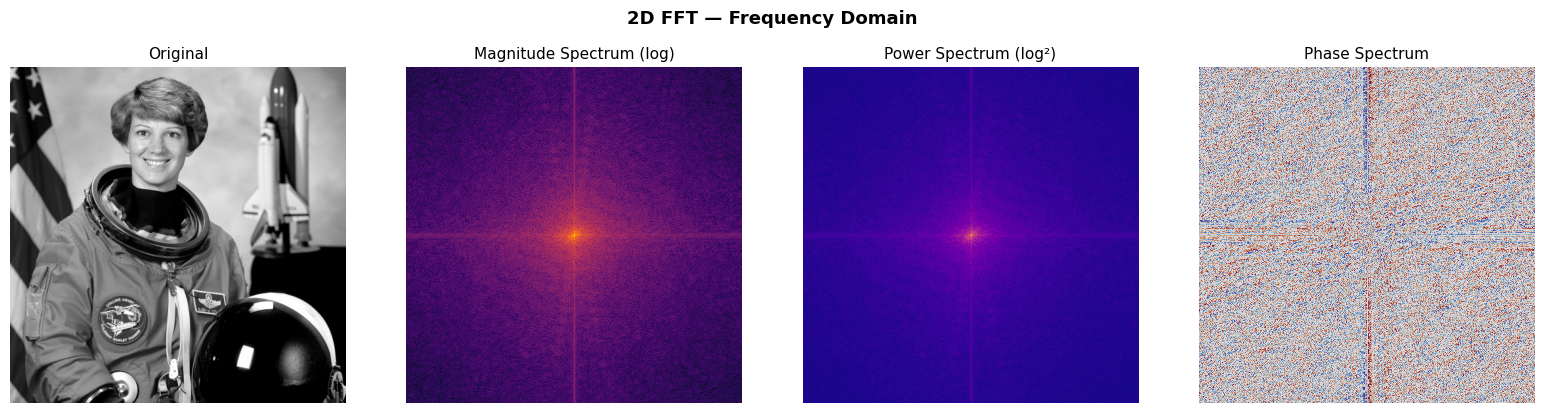

In [4]:
# ── 2D FFT ────────────────────────────────────────────────────────────────────
F      = fft2(img)
Fshift = fftshift(F)            # shift DC component to centre

magnitude   = np.log1p(np.abs(Fshift))          # log scale for visibility
power       = magnitude ** 2
phase       = np.angle(Fshift)

show(
    [img, magnitude, power, phase],
    ['Original', 'Magnitude Spectrum (log)', 'Power Spectrum (log²)', 'Phase Spectrum'],
    cmap=['gray', 'inferno', 'plasma', 'twilight_shifted'],
    suptitle='2D FFT — Frequency Domain'
)

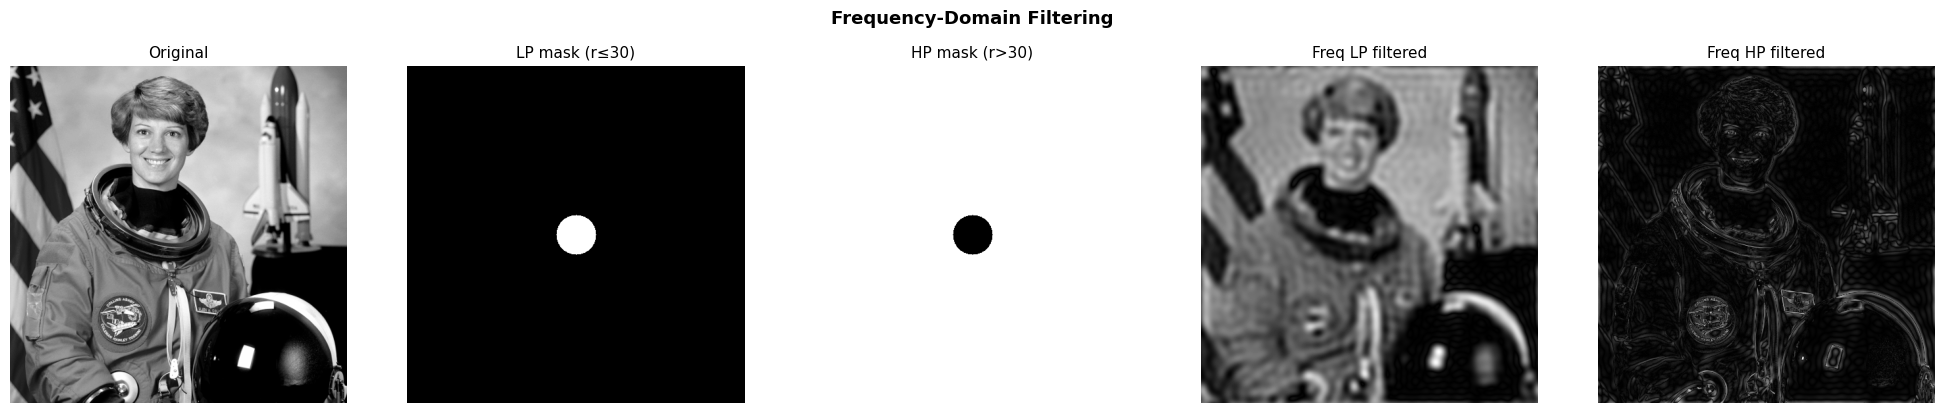

In [5]:
# ── Ideal frequency-domain filters ───────────────────────────────────────────
rows, cols = img.shape
cx, cy = rows // 2, cols // 2

def radial_mask(rows, cols, cutoff):
    """Boolean mask: True where distance from centre <= cutoff."""
    Y, X = np.ogrid[:rows, :cols]
    dist = np.sqrt((Y - cx)**2 + (X - cy)**2)
    return dist <= cutoff

cutoff = 30      # ← tune: radius in frequency-domain pixels

lp_mask = radial_mask(rows, cols, cutoff).astype(float)
hp_mask = 1 - lp_mask

def freq_filter(Fshift, mask):
    """Apply a frequency-domain mask and return the filtered image."""
    filtered = ifft2(ifftshift(Fshift * mask))
    return np.abs(filtered)

lp_img = freq_filter(Fshift, lp_mask)
hp_img = freq_filter(Fshift, hp_mask)
hp_img_disp = (hp_img - hp_img.min()) / (hp_img.max() - hp_img.min())

show(
    [img, lp_mask, hp_mask, lp_img, hp_img_disp],
    ['Original',
     f'LP mask (r≤{cutoff})', f'HP mask (r>{cutoff})',
     'Freq LP filtered', 'Freq HP filtered'],
    cmap=['gray', 'gray', 'gray', 'gray', 'gray'],
    suptitle='Frequency-Domain Filtering'
)

---
## 3 · Edge Detection

| Method | How it works |
|---|---|
| **Sobel** | First-order gradient; horizontal + vertical kernels |
| **Laplacian** | Second-order derivative; detects zero-crossings |
| **Canny** | Multi-step: Gaussian smooth → Sobel gradient → NMS → hysteresis |

Canny is generally the most robust because it suppresses noise and uses hysteresis thresholding.

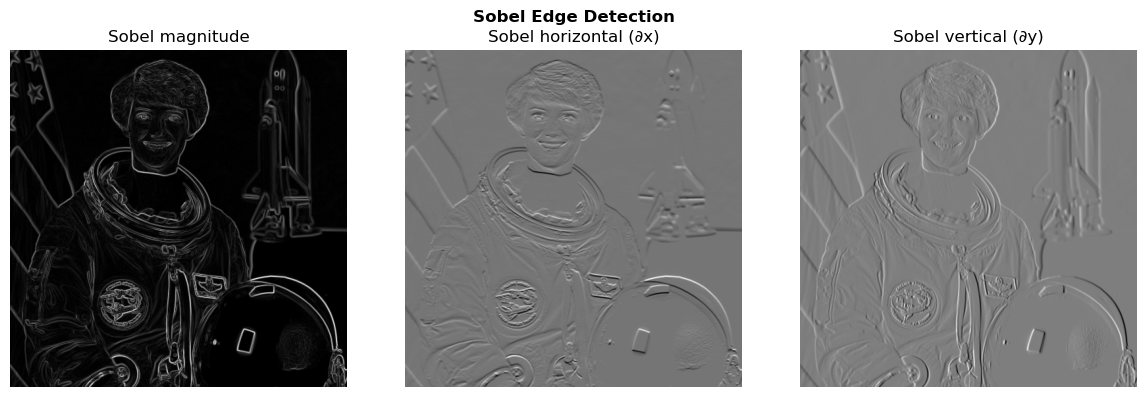

In [6]:
# ── Sobel ─────────────────────────────────────────────────────────────────────
sobel_edges = sobel(img)
sobel_norm  = sobel_edges / sobel_edges.max()

# Directional components
sobel_h = ndimage.sobel(img, axis=0)   # horizontal gradient
sobel_v = ndimage.sobel(img, axis=1)   # vertical gradient

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, data_img, title in zip(
    axes,
    [sobel_norm, sobel_h, sobel_v],
    ['Sobel magnitude', 'Sobel horizontal (∂x)', 'Sobel vertical (∂y)']
):
    ax.imshow(data_img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
fig.suptitle('Sobel Edge Detection', fontweight='bold')
plt.tight_layout()
plt.show()

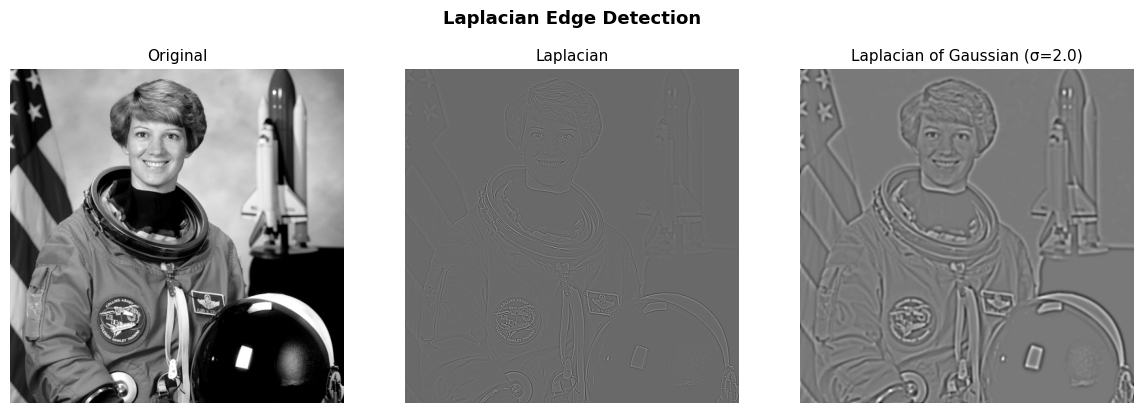

In [7]:
# ── Laplacian ─────────────────────────────────────────────────────────────────
laplace_edges = laplace(img)
laplace_norm  = (laplace_edges - laplace_edges.min()) / (laplace_edges.max() - laplace_edges.min())

# LoG: Laplacian of Gaussian (pre-smooth to reduce noise sensitivity)
log_sigma = 2.0    # ← tune: controls smoothing before Laplacian
log_smooth = gaussian(img, sigma=log_sigma)
log_edges  = laplace(log_smooth)
log_norm   = (log_edges - log_edges.min()) / (log_edges.max() - log_edges.min())

show(
    [img, laplace_norm, log_norm],
    ['Original', 'Laplacian', f'Laplacian of Gaussian (σ={log_sigma})'],
    suptitle='Laplacian Edge Detection'
)

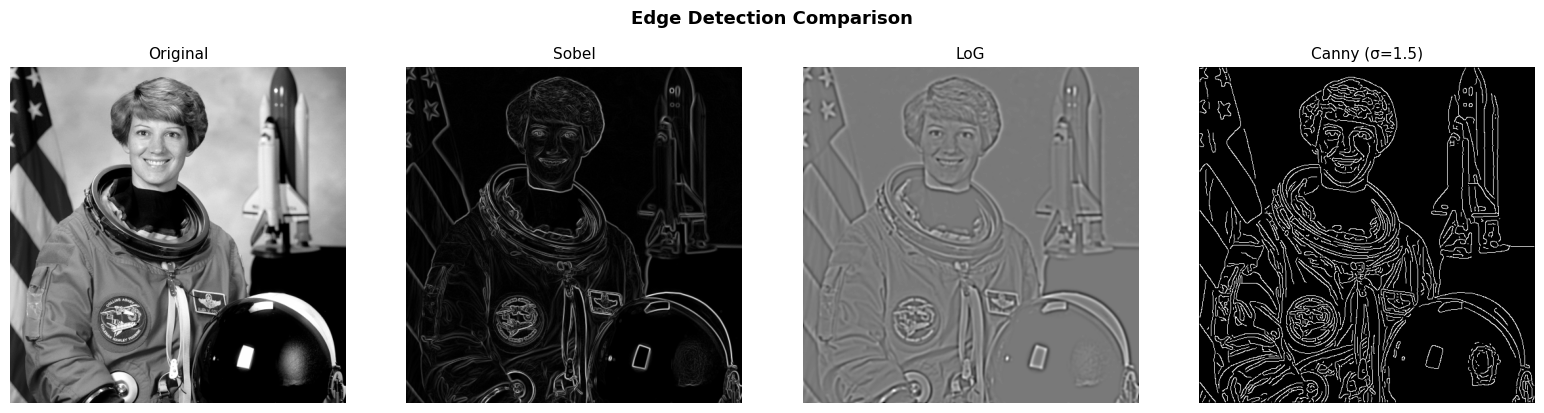

In [8]:
# ── Canny ─────────────────────────────────────────────────────────────────────
# Parameters:
canny_sigma = 1.5    # ← tune: Gaussian smoothing before gradient
low_thresh  = 0.05   # ← tune: weak edge threshold (fraction of max gradient)
high_thresh = 0.15   # ← tune: strong edge threshold

canny_edges = feature.canny(
    img,
    sigma=canny_sigma,
    low_threshold=low_thresh,
    high_threshold=high_thresh
)

# Compare all three methods side by side
show(
    [img, sobel_norm, log_norm, canny_edges],
    ['Original', 'Sobel', 'LoG', f'Canny (σ={canny_sigma})'],
    suptitle='Edge Detection Comparison'
)

---
## 4 · Noise: Addition & Removal

### 4a — Add Noise

| Type | Characteristics |
|---|---|
| **Gaussian** | Additive, normally distributed; models thermal/sensor noise |
| **Salt-and-pepper** | Random black/white pixels; models transmission errors |

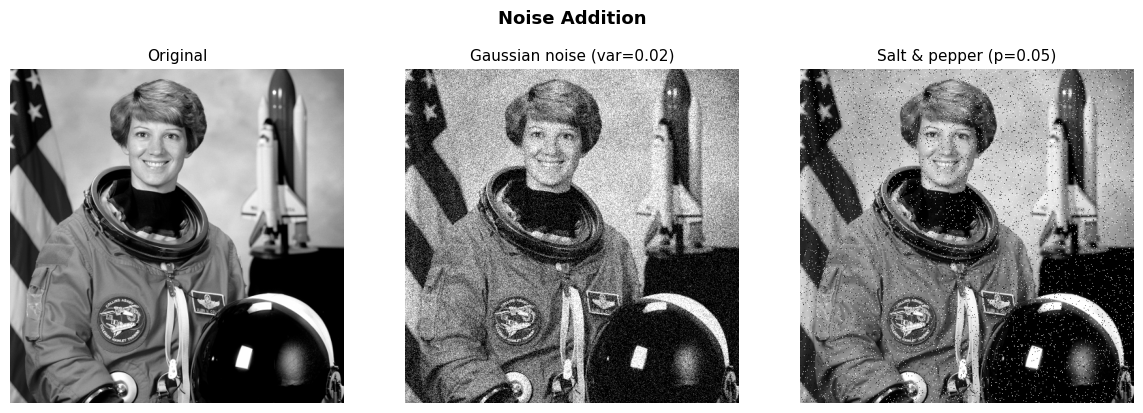

In [9]:
# ── Gaussian noise ────────────────────────────────────────────────────────────
gauss_noise_var = 0.02    # ← tune: variance (0.01–0.05 is visually noticeable)
img_gauss_noisy = util.random_noise(img, mode='gaussian', var=gauss_noise_var)

# ── Salt-and-pepper noise ─────────────────────────────────────────────────────
sp_amount = 0.05          # ← tune: fraction of corrupted pixels
img_sp_noisy = util.random_noise(img, mode='s&p', amount=sp_amount)

show(
    [img, img_gauss_noisy, img_sp_noisy],
    ['Original', f'Gaussian noise (var={gauss_noise_var})', f'Salt & pepper (p={sp_amount})'],
    suptitle='Noise Addition'
)

### 4b — Remove Noise

| Denoiser | Best for |
|---|---|
| **Gaussian filter** | Gaussian noise; fast but blurs edges |
| **Median filter** | Salt-and-pepper; edge-preserving |
| **Wiener filter** | Gaussian noise with known/estimated PSF; preserves more detail |
| **Total Variation (TV)** | Gaussian noise; piecewise-smooth result, sharp edges |

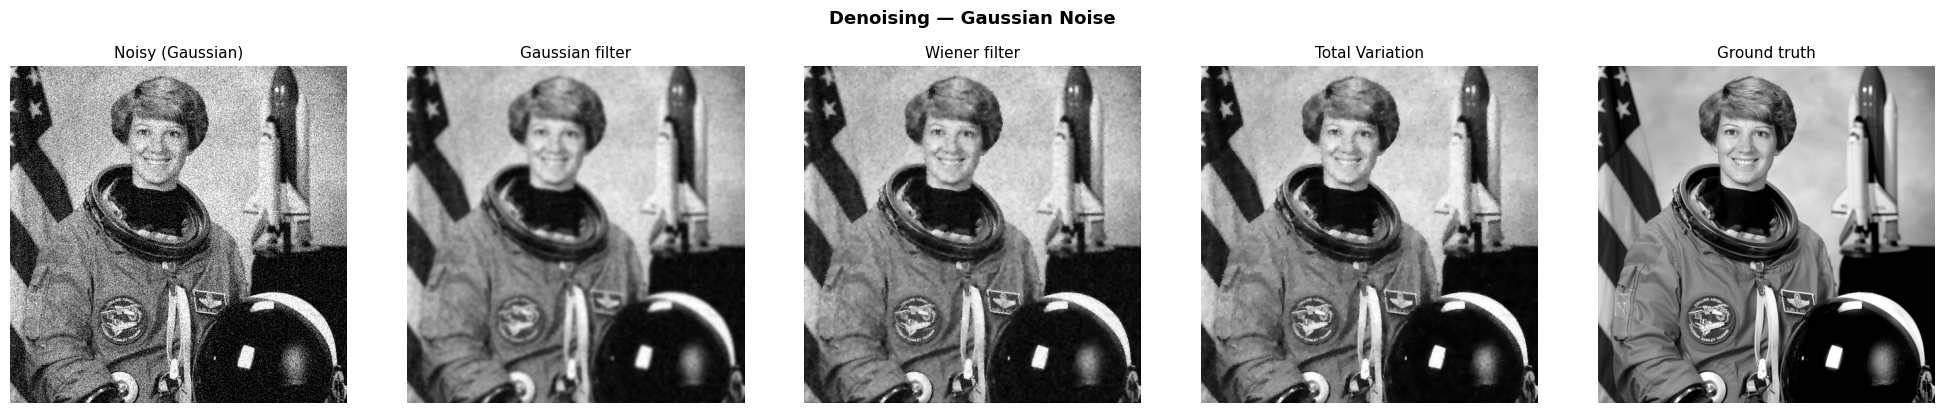

In [10]:
# ── Denoise Gaussian-noisy image ──────────────────────────────────────────────
denoised_gauss_gfilt  = gaussian(img_gauss_noisy, sigma=2)
denoised_gauss_wiener = signal.wiener(img_gauss_noisy, mysize=5, noise=gauss_noise_var)
denoised_gauss_tv     = restoration.denoise_tv_chambolle(img_gauss_noisy, weight=0.1)

show(
    [img_gauss_noisy, denoised_gauss_gfilt, denoised_gauss_wiener, denoised_gauss_tv, img],
    ['Noisy (Gaussian)', 'Gaussian filter', 'Wiener filter', 'Total Variation', 'Ground truth'],
    suptitle='Denoising — Gaussian Noise'
)

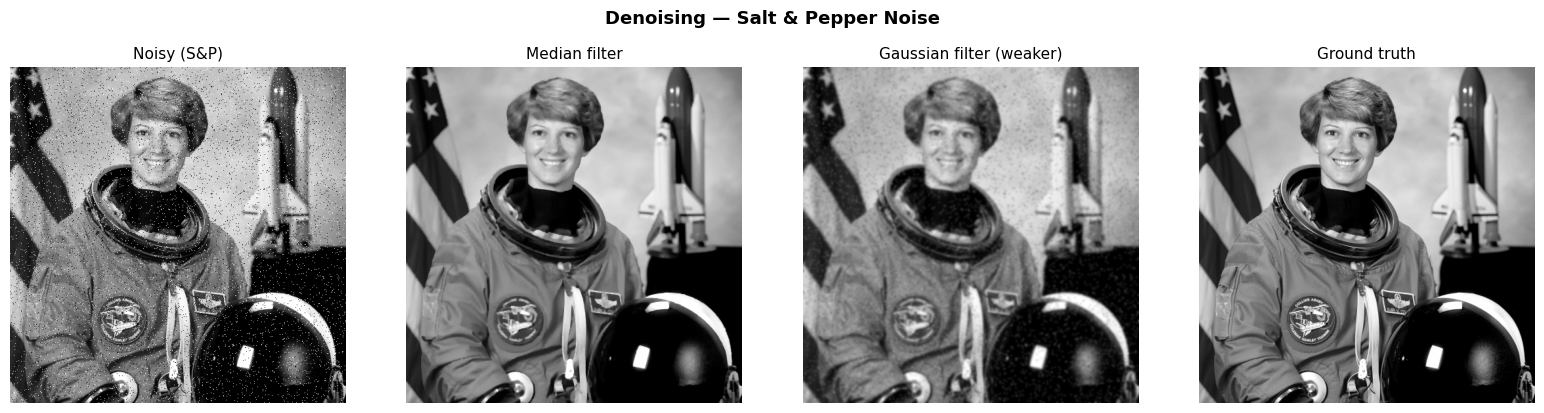

In [11]:
# ── Denoise salt-and-pepper image ─────────────────────────────────────────────
denoised_sp_median = median(img_sp_noisy, footprint=disk(2))
denoised_sp_gauss  = gaussian(img_sp_noisy, sigma=1.5)  # for comparison

show(
    [img_sp_noisy, denoised_sp_median, denoised_sp_gauss, img],
    ['Noisy (S&P)', 'Median filter', 'Gaussian filter (weaker)', 'Ground truth'],
    suptitle='Denoising — Salt & Pepper Noise'
)

### 4c — Quantitative comparison (PSNR & SSIM)

In [12]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def metrics(ref, candidate, label):
    p = psnr(ref, candidate, data_range=1.0)
    s = ssim(ref, candidate, data_range=1.0)
    print(f'{label:<30}  PSNR = {p:6.2f} dB   SSIM = {s:.4f}')

print('=== Gaussian noise denoising ===')
metrics(img, img_gauss_noisy,       'Noisy input')
metrics(img, denoised_gauss_gfilt,  'Gaussian filter')
metrics(img, denoised_gauss_wiener, 'Wiener filter')
metrics(img, denoised_gauss_tv,     'Total Variation')

print()
print('=== Salt & pepper denoising ===')
metrics(img, img_sp_noisy,        'Noisy input')
metrics(img, denoised_sp_median,  'Median filter')
metrics(img, denoised_sp_gauss,   'Gaussian filter')

=== Gaussian noise denoising ===
Noisy input                     PSNR =  17.77 dB   SSIM = 0.2676
Gaussian filter                 PSNR =  23.72 dB   SSIM = 0.6574
Wiener filter                   PSNR =  25.00 dB   SSIM = 0.6131
Total Variation                 PSNR =  25.98 dB   SSIM = 0.6729

=== Salt & pepper denoising ===
Noisy input                     PSNR =  17.70 dB   SSIM = 0.4055
Median filter                   PSNR =  30.29 dB   SSIM = 0.9418
Gaussian filter                 PSNR =  25.12 dB   SSIM = 0.6952


---
## 5 · Full Pipeline: End-to-End Demo

Combines noise → denoise → edge detection in one figure.

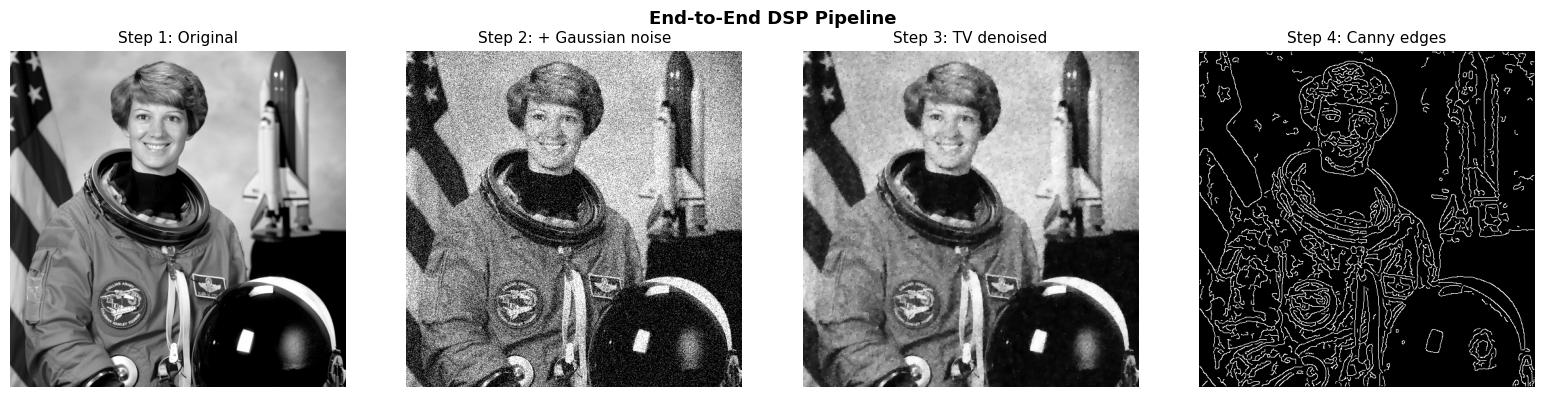

In [13]:
noisy    = util.random_noise(img, mode='gaussian', var=0.03)
denoised = restoration.denoise_tv_chambolle(noisy, weight=0.1)
edges    = feature.canny(denoised, sigma=1.5)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
steps = [
    (img,      'Step 1: Original'),
    (noisy,    'Step 2: + Gaussian noise'),
    (denoised, 'Step 3: TV denoised'),
    (edges,    'Step 4: Canny edges'),
]
for ax, (im, title) in zip(axes, steps):
    ax.imshow(im, cmap='gray')
    ax.set_title(title, fontsize=11)
    ax.axis('off')
fig.suptitle('End-to-End DSP Pipeline', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()